In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:

df = pd.read_csv("Data/processed/311_legacy_raw_merged.csv")  

output_dir = "Data/Tableau"



/var/folders/zg/rdp2_g2s3nl0_bqzgg3499z40000gn/T/ipykernel_16604/4182368889.py:1: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data/processed/311_legacy_raw_merged.csv")  # change file as needed


## Parse dates and create computed SLA column

In [76]:


df['open_dt_parsed'] = pd.to_datetime(df['open_dt'], errors='coerce')
df['closed_dt_parsed'] = pd.to_datetime(df['closed_dt'], errors='coerce')
df['sla_target_dt_parsed'] = pd.to_datetime(df['sla_target_dt'], errors='coerce')

# Compute on-time
df['computed_on_time'] = np.where(
    (df['case_status'] == 'Closed') &
    df['sla_target_dt_parsed'].notna() &
    df['closed_dt_parsed'].notna(),
    np.where(df['closed_dt_parsed'] <= df['sla_target_dt_parsed'], 'ONTIME', 'OVERDUE'),
    np.nan
)


## Number of Open vs Closed Cases per Year

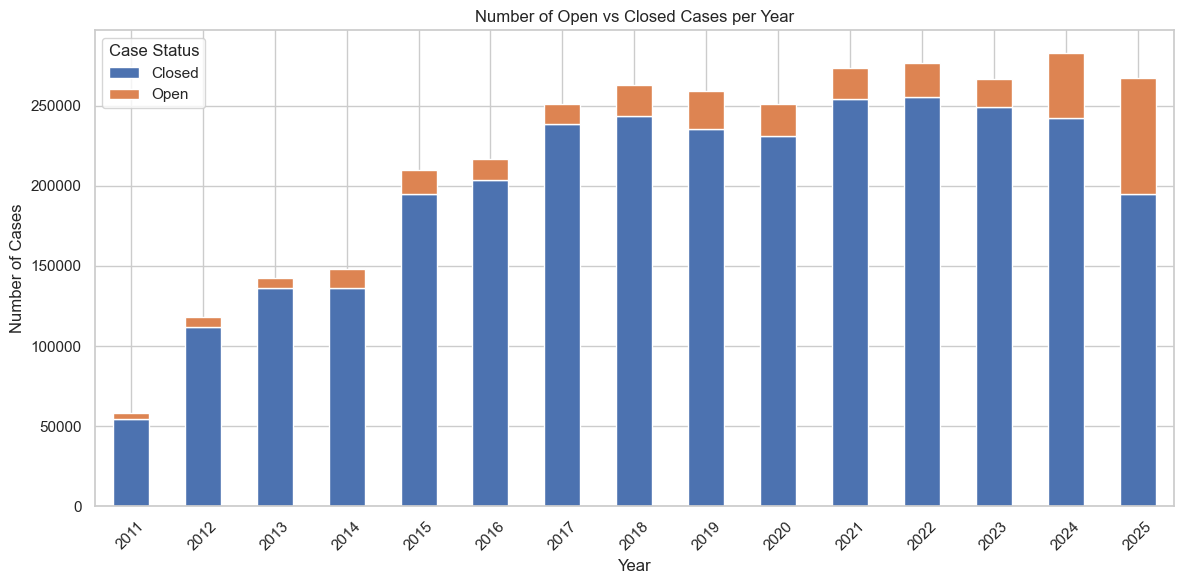

In [ ]:


df['open_dt_parsed'] = pd.to_datetime(df['open_dt'], errors='coerce')

df['open_year'] = df['open_dt_parsed'].dt.year

yearly_status_counts = (
    df
    .groupby(['open_year', 'case_status'])
    .size()
    .reset_index(name='case_count')
)


os.makedirs(output_dir, exist_ok=True)

yearly_status_counts.to_csv(
    f"{output_dir}/open_vs_closed_cases_by_year.csv",
    index=False
)


pivot_df = yearly_status_counts.pivot(
    index='open_year',
    columns='case_status',
    values='case_count'
).fillna(0)

pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.title('Number of Open vs Closed Cases per Year')
plt.xticks(rotation=45)
plt.legend(title='Case Status')
plt.tight_layout()
plt.show()


## Average Resolution Time per Year

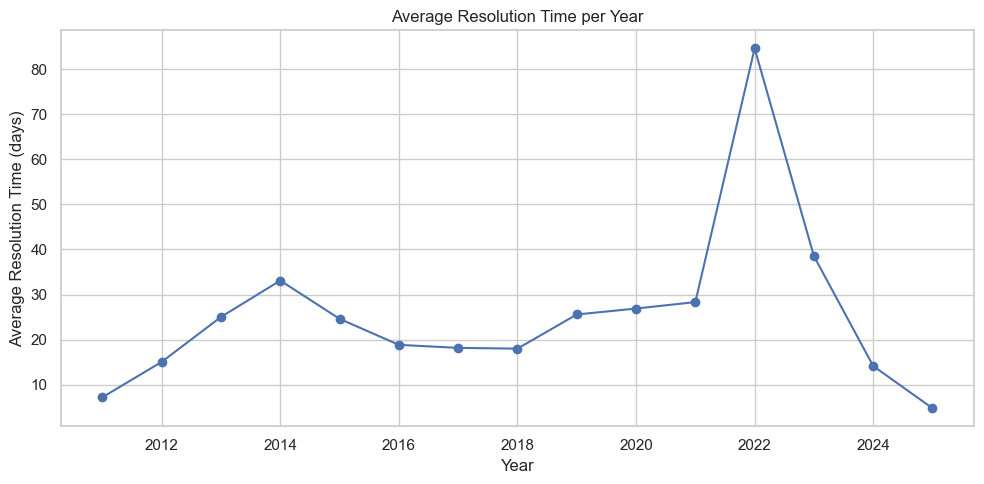

In [ ]:
df['resolution_time_days'] = (
    df['closed_dt_parsed'] - df['open_dt_parsed']
).dt.total_seconds() / (24 * 3600)

resolved_cases = df[
    (df['case_status'] == 'Closed') &
    df['resolution_time_days'].notna()
].copy()

resolved_cases['closed_year'] = resolved_cases['closed_dt_parsed'].dt.year

resolved_cases = resolved_cases[
    resolved_cases['closed_year'] <= 2025
]

yearly_avg = (
    resolved_cases
    .groupby('closed_year', as_index=False)['resolution_time_days']
    .mean()
)

os.makedirs(output_dir, exist_ok=True)

yearly_avg.to_csv(
    f"{output_dir}/average_resolution_time_by_year.csv",
    index=False
)


plt.figure(figsize=(10, 5))
plt.plot(
    yearly_avg['closed_year'],
    yearly_avg['resolution_time_days'],
    marker='o'
)
plt.xlabel('Year')
plt.ylabel('Average Resolution Time (days)')
plt.title('Average Resolution Time per Year')
plt.grid(True)
plt.tight_layout()
plt.show()


## Median Resolution Time Over Time

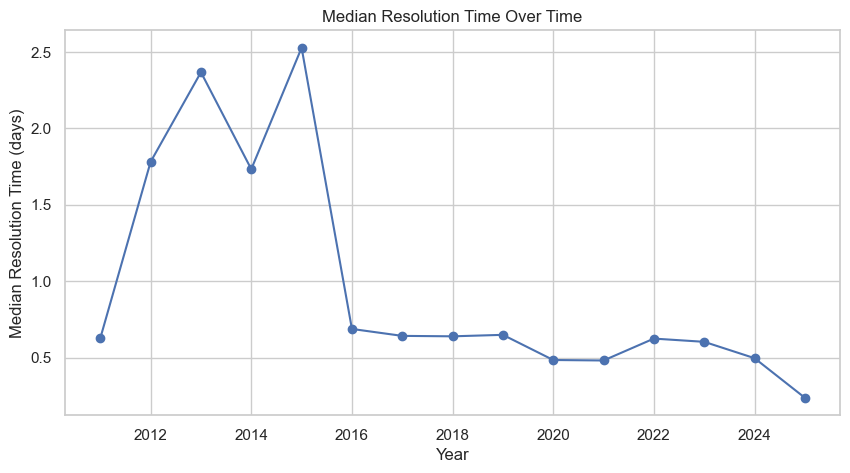

In [ ]:

df['resolution_time_days'] = (
    df['closed_dt_parsed'] - df['open_dt_parsed']
).dt.total_seconds() / (24 * 3600)

resolved = df[
    (df['case_status'] == 'Closed') &
    df['resolution_time_days'].notna()
].copy()

resolved['closed_year'] = resolved['closed_dt_parsed'].dt.year
resolved = resolved[resolved['closed_year'] <= 2025]

median_resolution = (
    resolved.groupby('closed_year')['resolution_time_days']
    .median()
    .reset_index()
)

os.makedirs(output_dir, exist_ok=True)

median_resolution.to_csv(
    f"{output_dir}/median_resolution_time_by_year.csv",
    index=False
)

plt.figure(figsize=(10,5))
plt.plot(
    median_resolution['closed_year'],
    median_resolution['resolution_time_days'],
    marker='o'
)
plt.xlabel('Year')
plt.ylabel('Median Resolution Time (days)')
plt.title('Median Resolution Time Over Time')
plt.grid(True)
plt.show()


## SLA Compliance Over Time

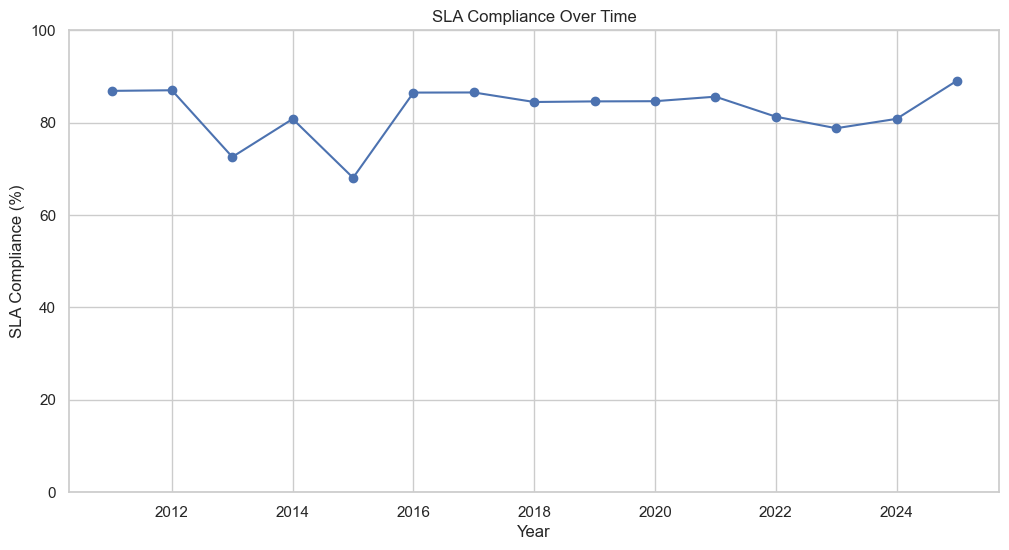

In [ ]:

df['closed_year'] = df['closed_dt_parsed'].dt.year


sla_df = df[
    (df['case_status'] == 'Closed') &
    (df['computed_on_time'].isin(['ONTIME', 'OVERDUE']))
].copy()

sla_df = sla_df[sla_df['closed_year'] <= 2025]

sla_by_year = (
    sla_df
    .groupby('closed_year')['computed_on_time']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

sla_by_year = sla_by_year * 100

os.makedirs(output_dir, exist_ok=True)

sla_by_year.reset_index().to_csv(
    f"{output_dir}/sla_compliance_by_year.csv",
    index=False
)


plt.figure(figsize=(12,6))
plt.plot(
    sla_by_year.index,
    sla_by_year['ONTIME'],
    marker='o'
)
plt.xlabel('Year')
plt.ylabel('SLA Compliance (%)')
plt.title('SLA Compliance Over Time')
plt.ylim(0, 100)
plt.grid(True)
plt.show()


## Overall SLA Compliance (SLA-Evaluable Cases)

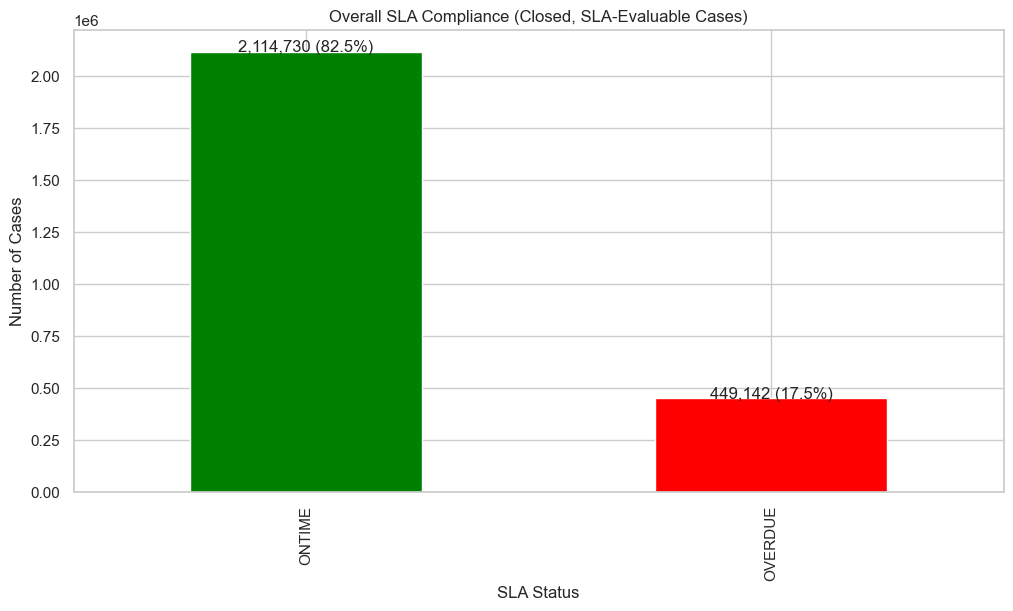

In [ ]:
sla_plot_df = df[
    (df['case_status'] == 'Closed') &
    (df['computed_on_time'].isin(['ONTIME', 'OVERDUE']))
].copy()


counts = sla_plot_df['computed_on_time'].value_counts()
percent = counts / counts.sum() * 100

os.makedirs(output_dir, exist_ok=True)

overall_sla_df = counts.reset_index()
overall_sla_df.columns = ['SLA_Status', 'Case_Count']
overall_sla_df['Percentage'] = percent.values

overall_sla_df.to_csv(
    f"{output_dir}/overall_sla_compliance.csv",
    index=False
)

ax = counts.plot(kind='bar', color=['green', 'red'])
plt.ylabel('Number of Cases')
plt.xlabel('SLA Status')
plt.title('Overall SLA Compliance (Closed, SLA-Evaluable Cases)')

for i, v in enumerate(counts):
    ax.text(i, v + 200, f"{v:,} ({percent[i]:.1f}%)", ha='center')

plt.show()


## Top 5 Departments SLA Compliance for Closed Cases

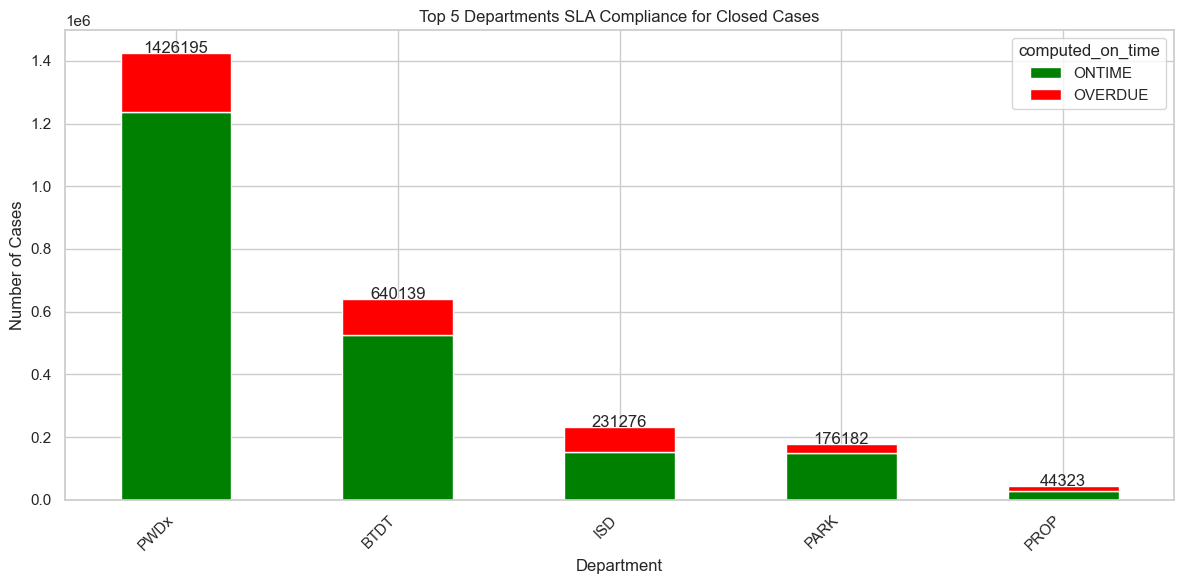

In [ ]:

sla_plot_df = df[
    (df['case_status'] == 'Closed') &
    (df['sla_target_dt'].notna()) &
    (df['closed_dt'].notna()) &
    (df['computed_on_time'].isin(['ONTIME','OVERDUE']))
].copy()

dept_sla_wide = pd.crosstab(
    sla_plot_df['department'], 
    sla_plot_df['computed_on_time']
)

dept_sla_wide = dept_sla_wide.reindex(columns=['ONTIME','OVERDUE'], fill_value=0)

dept_sla_wide = dept_sla_wide.loc[dept_sla_wide.sum(axis=1).sort_values(ascending=False).index[:5]]

dept_sla_long = dept_sla_wide.reset_index().melt(
    id_vars='department',
    value_vars=['ONTIME','OVERDUE'],
    var_name='SLA_Status',
    value_name='Count'
)
output_dir = "Data/Tableau"
os.makedirs(output_dir, exist_ok=True)
dept_sla_long.to_csv(f"{output_dir}/top5_department_sla.csv", index=False)

ax = dept_sla_wide.plot(
    kind='bar', stacked=True, color=['green','red'], figsize=(12,6)
)
plt.ylabel('Number of Cases')
plt.xlabel('Department')
plt.title('Top 5 Departments SLA Compliance for Closed Cases')
plt.xticks(rotation=45, ha='right')

for i, dept in enumerate(dept_sla_wide.index):
    total = dept_sla_wide.loc[dept, 'ONTIME'] + dept_sla_wide.loc[dept, 'OVERDUE']
    ax.text(i, total + 50, f"{total}", ha='center')

plt.tight_layout()
plt.show()


## Top 20 Request Types by Case Volume

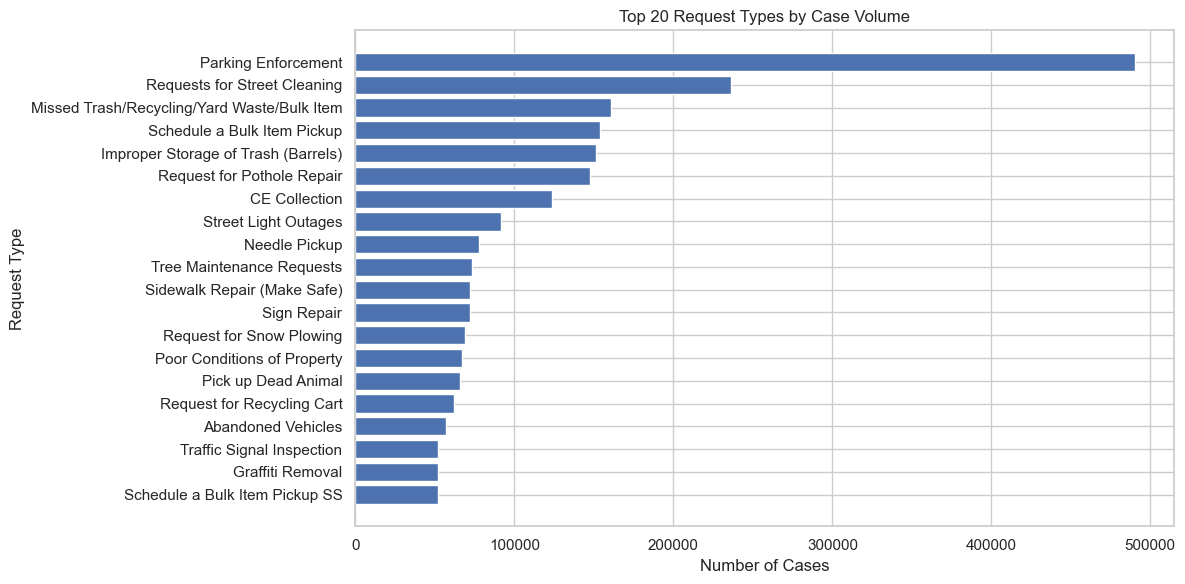

In [81]:

type_df = df[df['type'].notna()].copy()

type_counts = (
    type_df
    .groupby('type')
    .size()
    .reset_index(name='case_count')
    .sort_values('case_count', ascending=False)
    .head(20)
)

output_dir = "Data/Tableau"
os.makedirs(output_dir, exist_ok=True)

type_counts.to_csv(
    f"{output_dir}/top_20_request_types.csv",
    index=False
)

plt.figure(figsize=(12,6))
plt.barh(type_counts['type'], type_counts['case_count'])
plt.xlabel('Number of Cases')
plt.ylabel('Request Type')
plt.title('Top 20 Request Types by Case Volume')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



## Yearly Case Volume

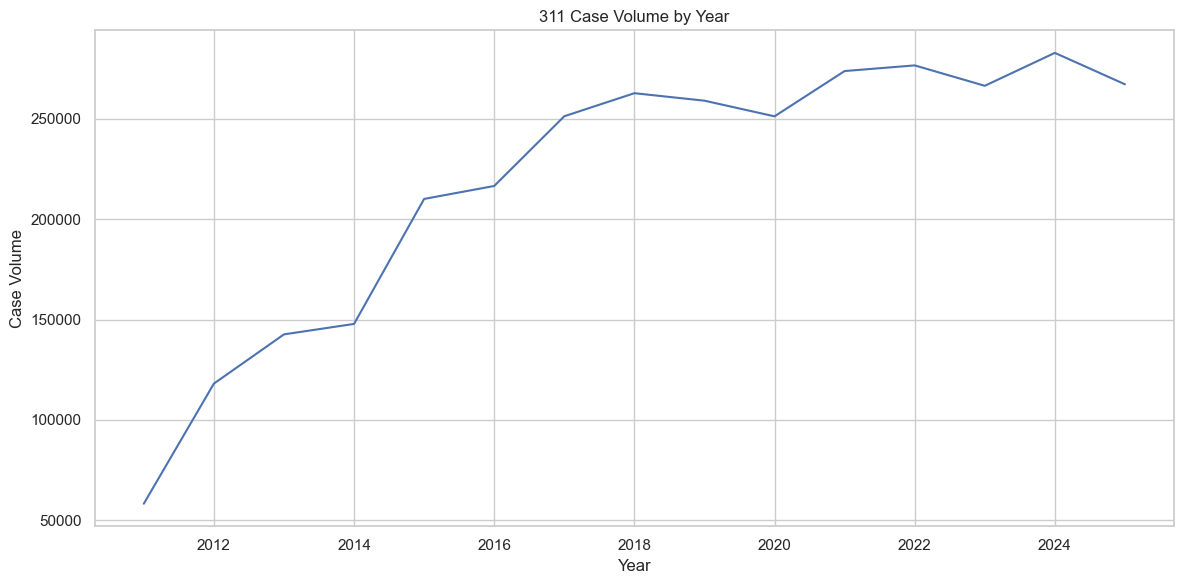

In [ ]:

df['open_dt_parsed'] = pd.to_datetime(df['open_dt'], errors='coerce')

df['open_year'] = df['open_dt_parsed'].dt.year

case_volume_df = df[df['open_year'].notna()].copy()

yearly_case_volume = (
    case_volume_df
    .groupby('open_year')
    .size()
    .reset_index(name='case_count')
    .sort_values('open_year')
)

os.makedirs(output_dir, exist_ok=True)

yearly_case_volume.to_csv(
    f"{output_dir}/yearly_case_volume.csv",
    index=False
)


plt.figure()
plt.plot(
    yearly_case_volume['open_year'],
    yearly_case_volume['case_count']
)
plt.xlabel("Year")
plt.ylabel("Case Volume")
plt.title("Case Volume by Year")
plt.tight_layout()
plt.show()

## Median Overdue Resolution Time by Year

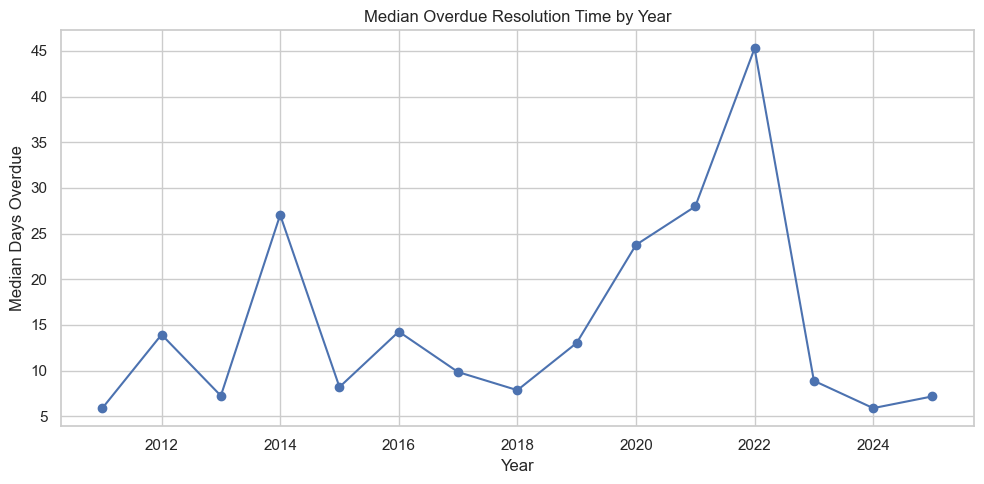

In [ ]:

df['overdue_days'] = (
    df['closed_dt_parsed'] - df['sla_target_dt_parsed']
).dt.total_seconds() / (24 * 3600)

overdue = df[
    (df['case_status'] == 'Closed') &
    df['sla_target_dt_parsed'].notna() &
    df['closed_dt_parsed'].notna() &
    (df['overdue_days'] > 0)
].copy()

overdue['closed_year'] = overdue['closed_dt_parsed'].dt.year
overdue = overdue[overdue['closed_year'] <= 2025]

median_overdue = (
    overdue
    .groupby('closed_year')['overdue_days']
    .median()
    .reset_index()
)


os.makedirs(output_dir, exist_ok=True)

median_overdue.to_csv(
    f"{output_dir}/median_overdue_days_by_year.csv",
    index=False
)

plt.figure(figsize=(10,5))
plt.plot(
    median_overdue['closed_year'],
    median_overdue['overdue_days'],
    marker='o'
)
plt.xlabel('Year')
plt.ylabel('Median Days Overdue')
plt.title('Median Overdue Resolution Time by Year')
plt.grid(True)
plt.tight_layout()
plt.show()


## SLA Compliance by Neighborhood

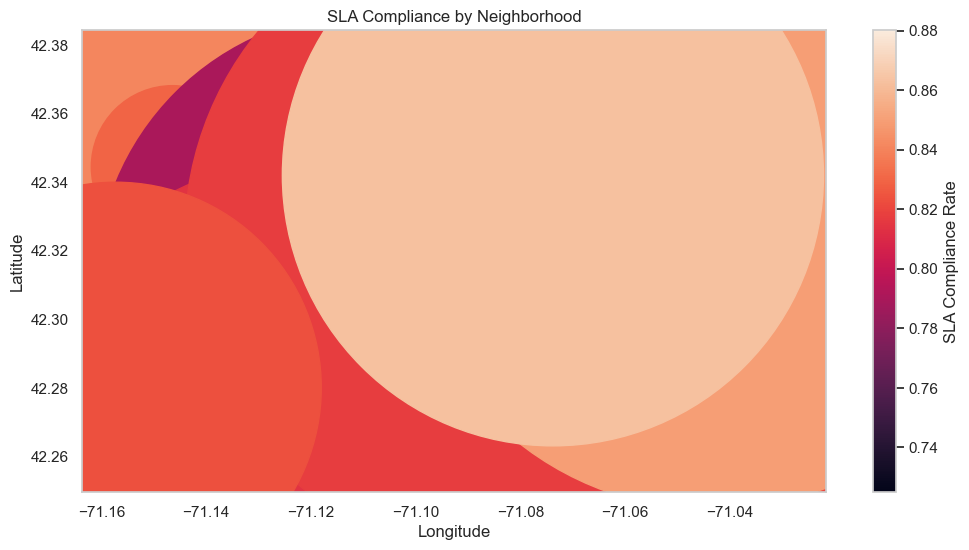

In [80]:
sla_map_df = df[
    (df['case_status'] == 'Closed') &
    (df['computed_on_time'].isin(['ONTIME', 'OVERDUE'])) &
    (df['neighborhood'].notna()) &
    (df['latitude'].notna()) &
    (df['longitude'].notna())
].copy()

sla_area = (
    sla_map_df
    .groupby('neighborhood')['computed_on_time']
    .value_counts()
    .unstack(fill_value=0)
)

sla_area = sla_area.reindex(columns=['ONTIME', 'OVERDUE'], fill_value=0)

sla_area['total_cases'] = sla_area['ONTIME'] + sla_area['OVERDUE']
sla_area['sla_compliance_rate'] = (
    sla_area['ONTIME'] / sla_area['total_cases']
)


sla_area = sla_area[sla_area['total_cases'] >= 30]

coords = (
    sla_map_df
    .groupby('neighborhood')[['latitude', 'longitude']]
    .mean()
)

sla_area = sla_area.join(coords, how='left')

os.makedirs(output_dir, exist_ok=True)

output_path = f"{output_dir}/sla_compliance_by_neighborhood.csv"

sla_area.reset_index().to_csv(
    output_path,
    index=False
)
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(
    sla_area['longitude'],
    sla_area['latitude'],
    s=sla_area['total_cases'],
    c=sla_area['sla_compliance_rate']
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("SLA Compliance by Neighborhood")
plt.colorbar(label="SLA Compliance Rate")
plt.show()
